Now plotting final results of k1...


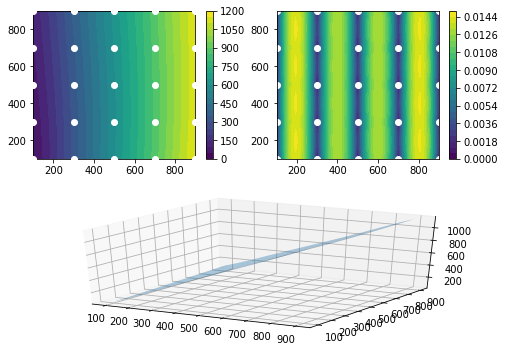

Now plotting final results of k2...


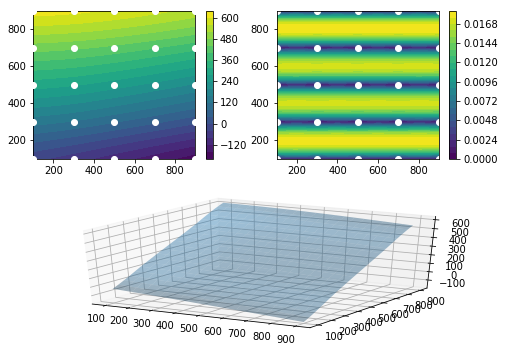

rms of linear fit: 11.84
rms of nonlinear fit: 0.00


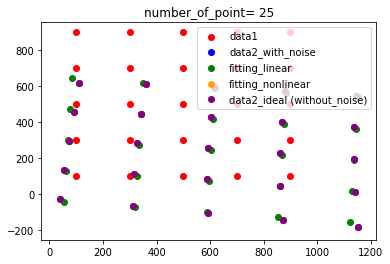

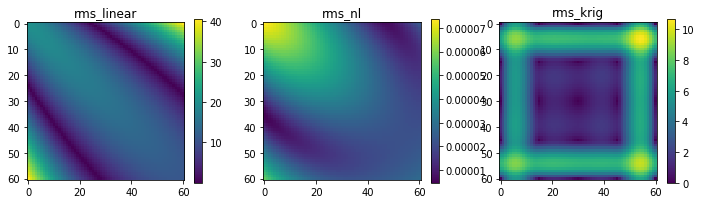

In [31]:
from __future__ import print_function

__author__ = 'cpaulson'
import pyKriging
from pyKriging.krige import kriging
from pyKriging.samplingplan import samplingplan

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import nltrans
import transformations
import pylab


def findcenter(self, img, blurRadius=211):
    assert blurRadius % 2 == 1, "blurRadius must be odd!"

    img = img.copy()
    if self.background is not None:
        img = img.astype('int32')
        img -= self.background
        img = np.clip(img, 0, 2 ** 8)
        img = img.astype('uint8')

    img = cv2.GaussianBlur(img, (blurRadius,) * 2, 0, 0)
    centroid_int = np.unravel_index(img.argmax(), img.shape)
    # TODO could detect a poor fit, and raise an Exception
    centroid_int = (centroid_int[1], centroid_int[0])

    return centroid_int


def zcalib(Zlevels, Zobjs):
    Zlevels = np.asarray(Zlevels)
    Zobjs = np.asarray(Zobjs)
    coefs = np.polyfit(Zobjs, Zlevels, deg=5)
    zmin = Zobjs.min() - .1 * (Zobjs.max() - Zobjs.min())
    zmax = Zobjs.max() + .1 * (Zobjs.max() - Zobjs.min())
    x = np.linspace(zmin, zmax, 500)
    plt.scatter(Zobjs, Zlevels)
    plt.plot(x, np.polyval(coefs, x))
    plt.xlabel("Z obj")
    plt.ylabel("Z level")
    # plt.xlim([zmin, zmax])
    # plt.ylim([zmin, zmax])
    plt.gca().set_aspect('equal')
    plt.plot(x, x, c='k')

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Zobjs, Zlevels)
    print("linear fit r-value: {0}".format(r_value))
    plt.plot(x, slope * x + intercept, 'g-')

    plt.show()


# zcalib([0,15, 35], [0, 10, 20])

def xycalib(data1, data2):
    #     circle_centers = [findcenter(img, 155) for img in self.circle_images]
    #     holo_imgs = [grab_point(pos[0], pos[1], 0) for pos in self.circle_positions]
    #
    #     holo_centers = [findcenter(img, 431) for img in holo_imgs]
    #
    #     calib1, err1 = transformations.fit_trans(np.asarray(circle_positions), np.asarray(circle_centers))
    #     calib2, err2 = transformations.fit_trans(np.asarray(holo_centers), np.asarray(circle_positions))
    data1 = np.asarray(np.array(data1))
    data2 = np.asarray(np.array(data2))
    calib1, err1 = transformations.fit_trans(data1, data2)
    return calib1, err1


def nlxycalib(data1, data2):
    #     circle_centers = [findcenter(img, 155) for img in self.circle_images]
    #     holo_imgs = [grab_point(pos[0], pos[1], 0) for pos in self.circle_positions]
    #
    #     holo_centers = [findcenter(img, 431) for img in holo_imgs]
    #
    #     calib1, err1 = transformations.fit_trans(np.asarray(circle_positions), np.asarray(circle_centers))
    #     calib2, err2 = transformations.fit_trans(np.asarray(holo_centers), np.asarray(circle_positions))
    data1 = np.asarray(np.array(data1))
    data2 = np.asarray(np.array(data2))
    calib1, err1 = nltrans.fit_trans(data1, data2)
    return calib1, err1


#####################################################
#####################################################
number_of_point = 5
size_of_img = 1000
noise_percentage = 0
noise = (np.random.rand(number_of_point* number_of_point,2) - 0.5) * (size_of_img * noise_percentage)

points_1 = np.linspace(size_of_img * 0.1, size_of_img * 0.9, num=number_of_point)
points_1 = np.meshgrid(points_1, points_1)
points_1 = np.reshape(np.ravel(points_1), (2, number_of_point ** 2)).T
# print('points_1' + str(points_1))
# points_1 = [[2, 3], [6, 4], [4, 6], [5, 2]]

# ideal_trans = [[0.95, 0.1, 0], [-0.1, 0.99, 0]]
# ideal_trans = [[0.95, 0.1, 0, 0], [-0.1, 0.99, 0, 0]]
ideal_trans = [[1.2, -0.1, 0.2, -100], [0, 1, -0.2, -100]]
# data2 = [[1.1, 3], [3.7, 5], [1.8, 6.2], [2.9, 1.2]]

points_2_ideal = nltrans.applytrans(points_1, ideal_trans)
points_2 = nltrans.applytrans(points_1, ideal_trans) + noise
(calib, err) = xycalib(points_1, points_2)
data1_dot_calib = transformations.applytrans(points_1, calib)
(nlcalib1, nlerr) = nlxycalib(points_1, points_2)
data1_dot_nlcalib = nltrans.applytrans(points_1, nlcalib1)

# testfun = pyKriging.testfunctions().cosine
k1 = kriging(points_1, points_2[:, 0], name='simple', testPoints=25)
k1.train(optimizer='ga')
k1.snapshot()
print('Now plotting final results of k1...')
X, Y, kx = k1.plot()
###########################
k2 = kriging(points_1, points_2[:, 1], name='simple', testPoints=25)
k2.train(optimizer='ga')
k2.snapshot()
print('Now plotting final results of k2...')
X, Y, ky = k2.plot()

#
#
# data1 = np.asarray(np.array(data1))
# data2 = np.asarray(np.array(data2))
# data1_dot_calib1 = nltrans.applytrans(data1, calib1)
# # noises[j] =  nltrans.rms(ideal_data2, data1_dot_calib1) / nltrans.rms(data2, data1_dot_calib1)
# #     plt.subplot(121)
# #     plt.scatter(number_of_point, noises[j], color='red')
# #
# #
# # plt.subplot(122)
# # plt.scatter(number_of_point, np.mean(noises), color='blue')
# # plt.errorbar(number_of_point, np.mean(noises), np.std(noises), color='blue')
#
print('rms of linear fit: ' + str("%.2f" % nltrans.rms(data1_dot_calib, points_2_ideal)))
print('rms of nonlinear fit: ' + str("%.2f" % nltrans.rms(data1_dot_nlcalib, points_2_ideal)))
plt.title('number_of_point= ' + str(number_of_point ** 2))
plt.scatter(points_1[:, 0], points_1[:, 1], color='red')
plt.scatter(points_2[:, 0], points_2[:, 1], color='blue')
plt.scatter(data1_dot_calib[:, 0], data1_dot_calib[:, 1], color='green')
plt.scatter(data1_dot_nlcalib[:, 0], data1_dot_nlcalib[:, 1], color='orange')
plt.scatter(points_2_ideal[:, 0], points_2_ideal[:, 1], color='purple')
# plt.scatter(kx, ky, color='black')
plt.legend(
    ['data1', 'data2_with_noise', 'fitting_linear', 'fitting_nonlinear', 'data2_ideal (without_noise)', 'Kriging'])
plt.show()

XY = np.dstack((X, Y))
XY = np.reshape(XY, (-1, 2))
idealXY = nltrans.applytrans(XY, ideal_trans)
linearXY = transformations.applytrans(XY, calib)
nlXY = nltrans.applytrans(XY, nlcalib1)
krigXY = np.dstack((kx, ky))
krigXY = np.reshape(krigXY, (-1, 2))

rms_linear = np.array(((linearXY[:, 0] - idealXY[:, 0]) ** 2 + (linearXY[:, 1] - idealXY[:, 1]) ** 2) ** 0.5)
rms_nl = np.array(((nlXY[:, 0] - idealXY[:, 0]) ** 2 + (nlXY[:, 1] - idealXY[:, 1]) ** 2) ** 0.5)
rms_krig = np.array(((krigXY[:, 0] - idealXY[:, 0]) ** 2 + (krigXY[:, 1] - idealXY[:, 1]) ** 2) ** 0.5)

rms_linear = np.reshape(rms_linear, (61, 61))
rms_nl = np.reshape(rms_nl, (61, 61))
rms_krig = np.reshape(rms_krig, (61, 61))

fig = pylab.figure(figsize=(12, 3))
fig.add_subplot(131)
plt.imshow(rms_linear)
plt.title('rms_linear')
# pylab.contourf(X, Y, rms_linear, 25)
pylab.colorbar()
fig.add_subplot(132)
plt.imshow(rms_nl)
plt.title('rms_nl')
# pylab.contourf(X, Y, rms_nl, 25)
pylab.colorbar()
fig.add_subplot(133)
plt.imshow(rms_krig)
plt.title('rms_krig')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()

#
# # plt.xlabel("number of points for calibration")
# # plt.subplot(121)
# # plt.ylabel("ratio of rms")
# # plt.show()


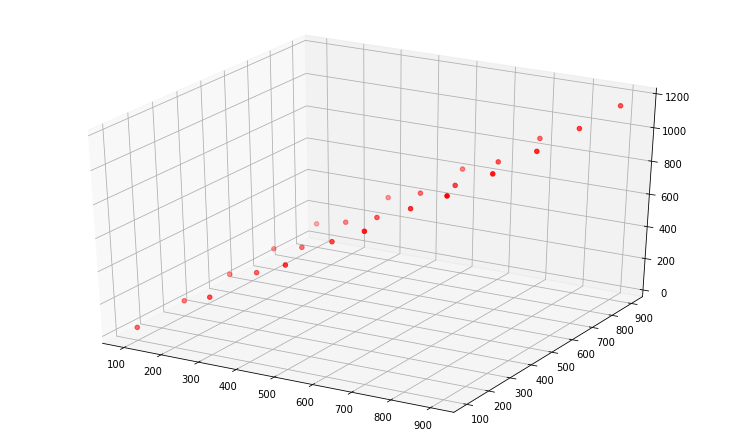

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
import random
# set seed to reproducible
random.seed(1)
data_size = 51
max_value_range = 1326
x = points_1[:,0]
y = points_1[:,1]
x1 = points_2[:,0]
y1 = points_2[:,1]




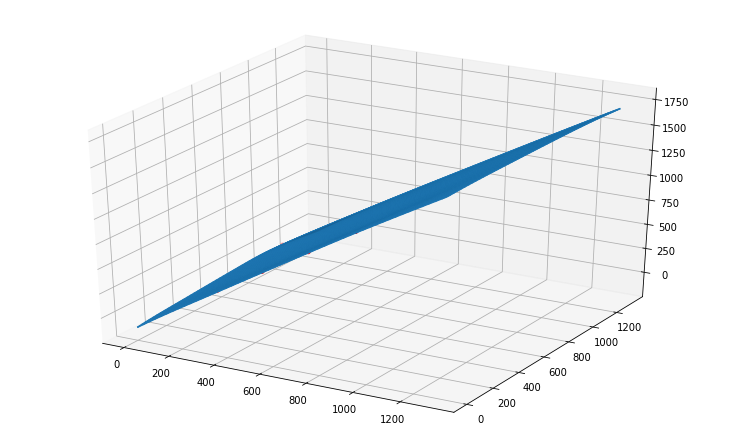

In [36]:
x_grid = np.linspace(0, 1326, 10*len(x))
y_grid = np.linspace(0, 1326, 10*len(y))
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = np.zeros((x.size, z.size))

import scipy as sp
import scipy.interpolate
spline_x = sp.interpolate.Rbf(x,y,x1,function='thin_plate',smooth=5, episilon=5)
spline_y = sp.interpolate.Rbf(x,y,y1,function='thin_plate',smooth=5, episilon=5)
spline_x(points1)


Z = spline(B1,B2)
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')